In [1]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import os
import pandas as pd
import sklearn.cluster as cluster
import shutil
import tsp

import sys
sys.path.append('./')
from normalization_function import *

In [2]:
class Normalized:
    def __init__(self, _min = None, _max = None, list_to_normalized = None):
        end_code = -1
        if _min != None and _max != None:
            self.__min = _min
            self.__max = _max
            end_code += 1
        if list_to_normalized != None:
            self.__min = min(list_to_normalized)
            self.__max = max(list_to_normalized)
            end_code += 1
        if end_code != 0:
            raise ValueError('Input parameters error.')

    def denormalized(self, y):
        return y * (self.__max - self.__min) + self.__min

    def denormalized_list(self, _list):
        return_list = []
        for y in _list:
            return_list.append(self.denormalized(y))
        return return_list

    def normalized(self, x):
        return (x - self.__min) / (self.__max - self.__min)

    def normalized_list(self, _list, to_reset = False):
        if to_reset:
            self.__min = min(_list)
            self.__max = max(_list)
        return_list = []
        for x in _list:
            return_list.append(self.normalized(x))
        return return_list

In [3]:
class Light:
    def __init__(self, _id, longitude, latitude, fixed_time = None):
        self.__id = _id
        self.__longitude = longitude
        self.__latitude = latitude
        self.set_fixed_time(fixed_time)
        self.set_cluster_id(None)

    def get_id(self):
        return self.__id
        
    def get_longitude(self):
        return self.__longitude

    def get_latitude(self):
        return self.__latitude

    def get_fixed_time(self):
        return self.__fixed_time

    def get_cluster_id(self):
        return self.__cluster_id

    def set_fixed_time(self, fixed_time):
        self.__fixed_time = fixed_time

    def set_cluster_id(self, cluster_id):
        self.__cluster_id = cluster_id

    def to_dict(self):
        return {
            'longitude': self.__longitude,
            'latitude': self.__latitude,
            'fixed_time': self.__fixed_time
        }

    @staticmethod
    def get_data_frame(lights_list):
        dict_list = []
        for light in lights_list:
            dict_list.append(light.to_dict())
        return pd.DataFrame.from_records(dict_list)

    @staticmethod
    def to_predict_cluster(lights_list, cluster_number):
        lights_data_frame = Light.get_data_frame(lights_list)
        kmeans = cluster.KMeans(n_clusters = cluster_number)
        y_predict = kmeans.fit_predict(lights_data_frame)
        for (i, light) in enumerate(lights_list):
            light.set_cluster_id(y_predict[i])

In [4]:
def read_cell(sheet, row_index, column_index):
    return sheet.cell(row = row_index, column = column_index).value

def read_column(row_number, target_column):
    return_list = []
    for col in loadsheet.iter_cols(min_row = row_number, min_col = target_column, max_col = target_column):
        for cell in col:
            return_list.append(cell.value)
    return return_list

def RGB(R, G, B):
    return (R / 255, G / 255, B / 255)

In [5]:
CLUSTER_NUMBER = 4
COLOR_LIST = [RGB(255, 0, 0), RGB(0, 255, 0), RGB(0, 0, 255), RGB(0, 255, 255), RGB(255, 0, 255), RGB(255, 255, 0)]
START_ROW_INDEX = 4

# open file
loadfile = '../data/data1.xlsx'
loadbook = openpyxl.load_workbook(loadfile)

# get sheet in the file
loadsheet = loadbook[loadbook.sheetnames[0]]

In [6]:
# normalized
longitude = read_column(START_ROW_INDEX, 19)
longitude_normalizer = Normalized(list_to_normalized = longitude)
normalized_longitude = longitude_normalizer.normalized_list(longitude)

latitude = read_column(START_ROW_INDEX, 20)
latitude_normalizer = Normalized(list_to_normalized = latitude)
normalized_latitude = latitude_normalizer.normalized_list(latitude)

fixed_time = time_normalization_datetime(loadsheet, START_ROW_INDEX, 16, 16)
fixed_time_normalizer = Normalized(list_to_normalized = fixed_time)
normalized_fixed_time = fixed_time_normalizer.normalized_list(fixed_time)

lights = []
for i in range(0, loadsheet.max_row + 1 - START_ROW_INDEX):
    _id = read_cell(loadsheet, i + START_ROW_INDEX, 2).replace('\xa0', '')
    longitude = normalized_longitude[i]
    latitude = normalized_latitude[i]
    fixed_time = normalized_fixed_time[i]
    lights.append(Light(_id, longitude, latitude, fixed_time))

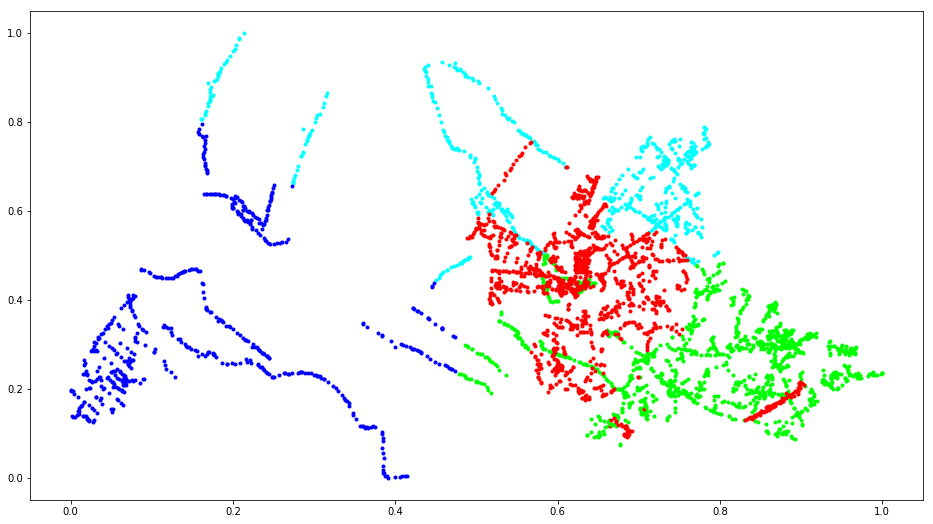

In [7]:
Light.to_predict_cluster(lights_list = lights, cluster_number = CLUSTER_NUMBER)
plt.figure(figsize=(16, 9))
for light in lights:
    plt.plot(light.get_longitude(), light.get_latitude(), '.', color = COLOR_LIST[light.get_cluster_id()])
plt.show()